In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import astropy.units as u # I use astropy units in everything, very helpful for bookkeeping/debugging

from lim import lim # The base intensity mapping object

matplotlib.rcParams.update({'font.size': 18,'figure.figsize':[8,7]}) # Make figures better
#matplotlib.rcParams,update({}'figure.figsize'] = [8,7]
from scipy.ndimage import gaussian_filter

In [2]:
import math

In [3]:
# Initialize LineModel with default model
m_co = lim()

In [4]:
m_co = lim('TonyLi_PhI', doSim = True)

Input cosmological model does not match simulations
Setting analytic cosmology to match simulation


In [6]:
pure_co = m_co.maps

Loading .npz catalogues...


In [7]:
np.shape(pure_co)

(354, 354, 22)

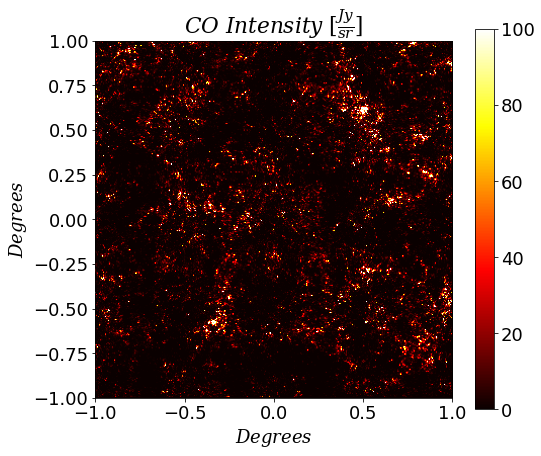

In [21]:
plt.imshow(pure_co[:, :, 3].value, vmax = 100, cmap =  'hot', extent = [-1, 1, -1, 1])
plt.title(r'$CO\ Intensity\ [\frac{Jy}{sr}]$', math_fontfamily = 'dejavuserif')
plt.xlabel(r'$Degrees$', math_fontfamily = 'dejavuserif')
plt.ylabel(r'$Degrees$', math_fontfamily = 'dejavuserif')
plt.colorbar()
plt.savefig('doga_CO_cb.pdf')

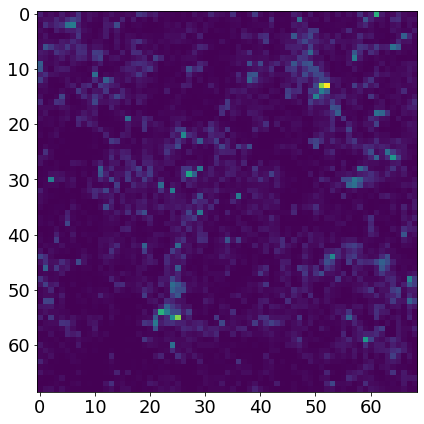

In [22]:
plt.imshow(np.mean((pure_co[:,:, ind - 6: ind + 6].value), axis = -1))

In [8]:
zs = (m_co.mapinst.nu_rest/m_co.mapinst.nu_bincents) - 1

In [9]:
cii_z = 6.025925925925924

In [10]:
ind = np.argmin(np.abs(zs - cii_z))

In [11]:
ind

3

In [ ]:
z_err = 0.08


In [20]:
np.ediff1d(zs)[ind]

0.00669141194816536

In [76]:
omega_f = 2.25*u.deg**2
fwhm = 4.1*u.arcmin

In [77]:
theta_s = np.sqrt(omega_f)
beam_w = fwhm*0.4247

In [80]:
int(np.round((theta_s/beam_w).decompose()))

52

In [11]:
coefs = np.linspace(0.01, 2, 1000)
def npixs(coef):
    omega_f = 2.25*u.deg**2
    fwhm = 4.1*u.arcmin
    theta_s = np.sqrt(omega_f)
    beam_w = fwhm*coef
    n = int(np.round((theta_s/beam_w).decompose()))
    return n

In [12]:
ns = [0 for i in range(len(coefs))]
for i in range(len(coefs)):
    ns[i] = npixs(coefs[i])

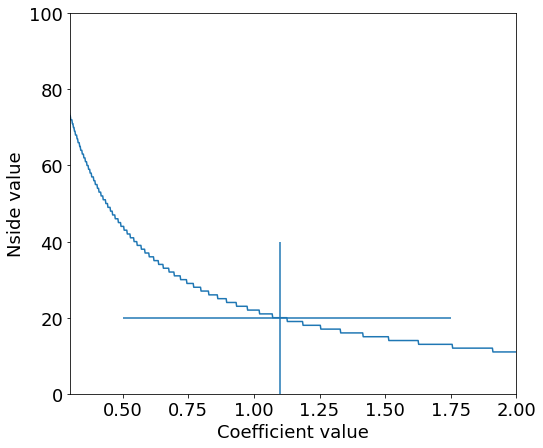

In [13]:
plt.plot(coefs, ns)
plt.xlim([0.3, 2])
plt.ylim([0, 100])
plt.xlabel('Coefficient value')
plt.ylabel('Nside value')
plt.hlines(y = 20, xmin = 0.5, xmax = 1.75)
plt.vlines(x = 1.1, ymin = 0, ymax = 40)

## Modeling HOD

In [7]:
halo_ms = m_co.halos.M

In [8]:
log_Mmin = 11.03 # at redshift = 5.9 and fainter UV threshold
sig_logM = 0.2

In [9]:
def N_c(M_h, sig, logM_min):
    
    return (1/2)*(1 + math.erf((np.log10(M_h) - logM_min)/(sig)))

In [10]:
N_cen = [0 for i in range(len(halo_ms))]
for i in range(len(halo_ms)):
    N_cen[i] = N_c(halo_ms[i], sig_logM, log_Mmin)

In [50]:
N_cen = np.array(N_cen)

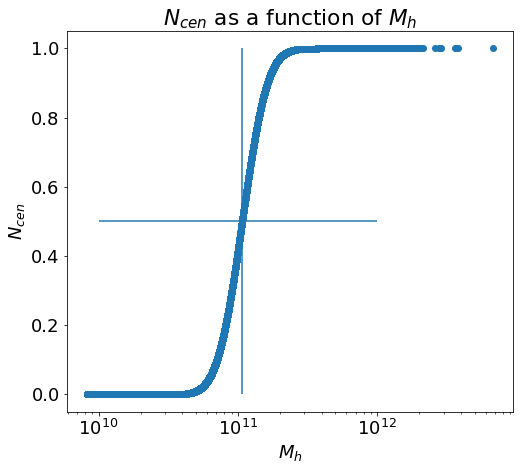

In [18]:
plt.scatter(halo_ms, N_cen)
plt.xscale('log')
plt.xlabel(r'$M_h$')
plt.ylabel(r'$N_{cen}$')
plt.title(r'$N_{cen}$ as a function of $M_h$')
plt.vlines(x = 10**log_Mmin, ymin = 0, ymax  = 1)
plt.hlines(y = 0.5, xmin = 10**10, xmax = 10**12)

In [11]:
def m1(logM_min):
    return 10**(1.18*logM_min - 1.28)

In [12]:
def m0(logM_min):
    return 10**(0.76*(1.18*logM_min - 1.28) + 2.3)

In [13]:
log_Mmin = 11.03
sig_logM = 0.2
alpha = 1.0
M_1 = m1(log_Mmin)
M_0 = m0(log_Mmin)

In [14]:
def N_s(M_h, sig, logM_min, M1, M0, alph):
    
    return N_c(M_h, sig, logM_min)*(((M_h - M0)/M1)**alph)

In [15]:
N_sat = [0 for i in range(len(halo_ms))]
for i in range(len(halo_ms)):
    N_sat[i] = N_s(halo_ms[i], sig_logM, log_Mmin, M_1, M_0, alpha)

In [16]:
N_sat = np.array(N_sat)

In [17]:
neg = np.array(N_sat) < 0
pos = np.array(N_sat) > 0
print(len(N_sat))
print(len(np.array(N_sat)[neg]))
print(len(np.array(N_sat)[pos]))

2502018
2490657
11361


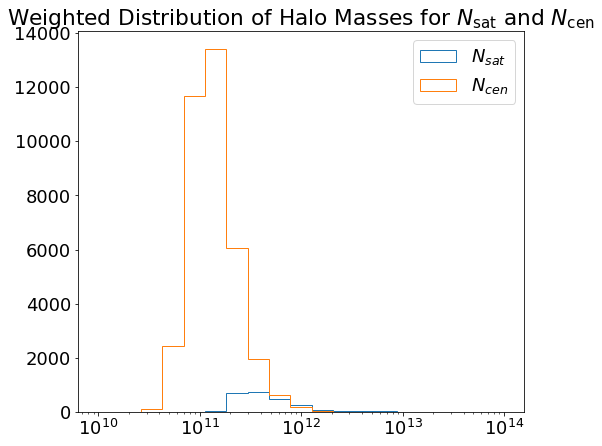

In [18]:
plt.hist(halo_ms[pos], weights = np.array(N_sat)[pos], bins = np.logspace(10, 14, 20), histtype='step', label = r'$N_{sat}$')
plt.hist(halo_ms, weights = N_cen, bins = np.logspace(10, 14, 20), histtype='step', label = r'$N_{cen}$')
plt.xscale('log')
plt.title(r'Weighted Distribution of Halo Masses for $N_{\rm{sat}}$ and $N_{\rm{cen}}$')
plt.legend()

In [19]:
def halo_centpix(halo_xpos, halo_ypos, halo_zs):
    
    '''
    Parameters
    ----------
    
    halo_xpos: array_like
               list of RA coordinates of halos, from the original distribution of halos
    
    halo_ypos: array_like
               list of DEC coordinates of halos, from the original distribution of halos
               
    
    Returns
    -------
    
    halo_centpix_x: array_like
                    list of the x-pixel positions of halos, mapped on the lim map
    
    
    halo_centpix_x: array_like
                    list of the y-pixel positions of halos, mapped on the lim map
    
    '''
    
    pixcents_x = m_co.mapinst.pix_bincents_x
    pixcents_y = m_co.mapinst.pix_bincents_y
    map_zs = (m_co.mapinst.nu_rest/m_co.mapinst.nu_bincents) - 1
    
    pixcents_x_mesh, halo_xs_mesh = np.meshgrid(pixcents_x, halo_xpos)
    halo_centpix_x = np.argmin(np.abs(halo_xs_mesh - pixcents_x_mesh), axis=1)
    
    pixcents_y_mesh, halo_ys_mesh = np.meshgrid(pixcents_y, halo_ypos)
    halo_centpix_y = np.argmin(np.abs(halo_ys_mesh - pixcents_y_mesh), axis=1)
    
    pixcents_z_mesh, halo_zs_mesh = np.meshgrid(map_zs, halo_zs)
    halo_centpix_z = np.argmin(np.abs(halo_zs_mesh - pixcents_z_mesh), axis=1)
    
    return halo_centpix_x, halo_centpix_y, halo_centpix_z

In [20]:
halo_ras = m_co.halos.ra
halo_decs = m_co.halos.dec
halo_zs = m_co.halos.redshift

In [21]:
halo_centpixx, halo_centpixy, halo_centpixz = halo_centpix(halo_ras, halo_decs, halo_zs)

In [22]:
co_map = m_co.maps
co_map = co_map.value

In [23]:
lum = [0 for i in range(len(halo_ras))]
for i in range(len(halo_ras)):
    lum[i] = co_map[int(halo_centpixx[i]), int(halo_centpixy[i]), int(halo_centpixz[i])]

In [24]:
lum = np.array(lum)

Text(0.5, 0, 'CO Intensity [$\\frac{Jy}{sr}$]')

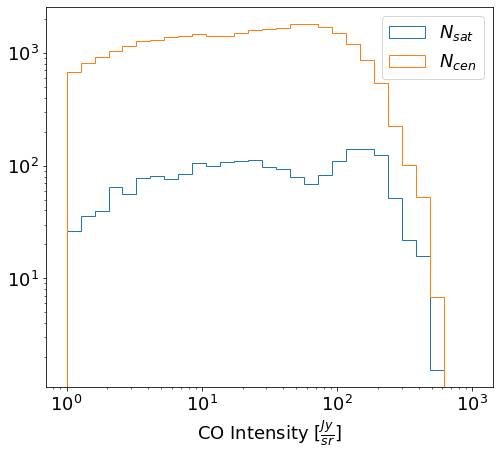

In [62]:
plt.hist(lum[pos], weights = np.array(N_sat)[pos], bins = np.logspace(0, 3, 30), histtype='step', label = r'$N_{sat}$')
plt.hist(lum, weights = N_cen, histtype='step', bins = np.logspace(0, 3, 30), label = r'$N_{cen}$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel(r'CO Intensity [$\frac{Jy}{sr}$]')

Text(0.5, 0, 'Normalized CO Intensity [$\\frac{Jy}{sr}$]')

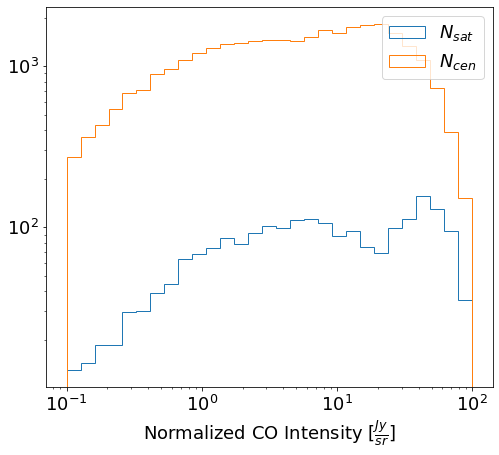

In [71]:
plt.hist(lum[pos]/(np.mean(co_map)), weights = np.array(N_sat)[pos], bins = np.logspace(-1, 2, 30), histtype='step', label = r'$N_{sat}$')
plt.hist(lum/(np.mean(co_map)), weights = N_cen, histtype='step', bins = np.logspace(-1, 2, 30), label = r'$N_{cen}$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel(r'Normalized CO Intensity [$\frac{Jy}{sr}$]')

In [25]:
def MH1_fit(M, M_0, M_min, alpha):
    x = M/M_min
    return M_0 * (x**alpha) * np.exp(-1/(x**0.35))

In [26]:
halo_HI = MH1_fit(halo_ms, (1.9*(10**9)), (2*(10**10)), (0.74))

Text(0.5, 0, 'HI Mass')

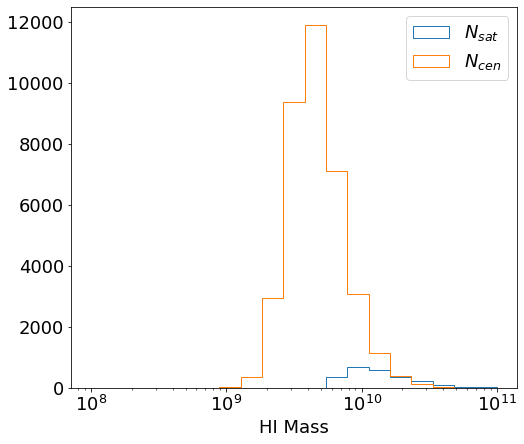

In [37]:
plt.hist(halo_HI[pos], weights = np.array(N_sat)[pos], bins = np.logspace(8, 11, 20), histtype='step', label = r'$N_{sat}$')
plt.hist(halo_HI, weights = N_cen, bins = np.logspace(8, 11, 20), histtype='step', label = r'$N_{cen}$')
plt.xscale('log')
plt.legend()
plt.xlabel('HI Mass')

Text(0.5, 0, 'CO brightness temperature per HI Mass')

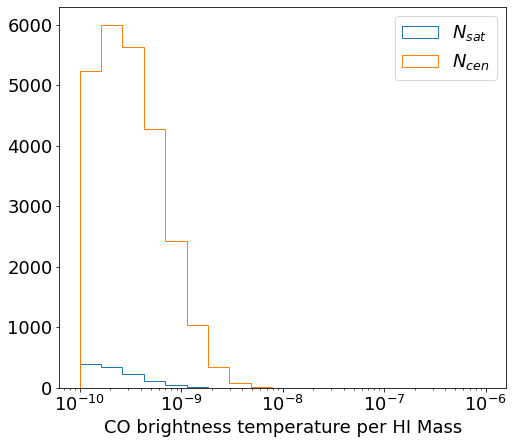

In [38]:
plt.hist((lum/halo_HI)[pos], weights = np.array(N_sat)[pos], bins = np.logspace(-10, -6, 20), histtype='step', label = r'$N_{sat}$')
plt.hist(lum/halo_HI, weights = N_cen, bins = np.logspace(-10, -6, 20), histtype='step', label = r'$N_{cen}$')
plt.xscale('log')
plt.legend()
plt.xlabel('CO Intensity per HI Mass')

Text(0.5, 0, 'CO brightness temperature per HI Mass')

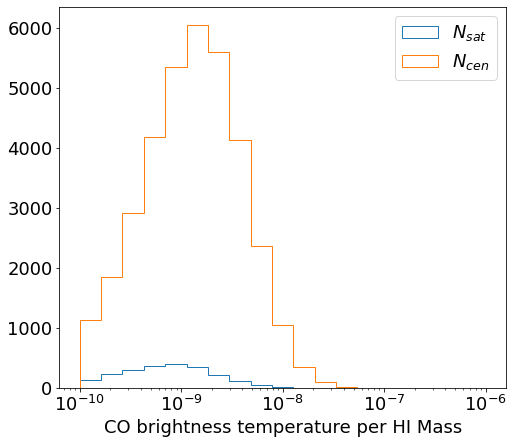

In [36]:
plt.hist((lum/halo_HI)[pos], weights = np.array(N_sat)[pos], bins = np.logspace(-10, -6, 20), histtype='step', label = r'$N_{sat}$')
plt.hist(lum/halo_HI, weights = N_cen, bins = np.logspace(-10, -6, 20), histtype='step', label = r'$N_{cen}$')
plt.xscale('log')
plt.legend()
plt.xlabel('CO brightness temperature per HI Mass')

Using the `Lco` attribute instead of the `maps` object:

In [27]:
lum_lco = m_co.halos.Lco

Text(0.5, 0, 'CO luminosity')

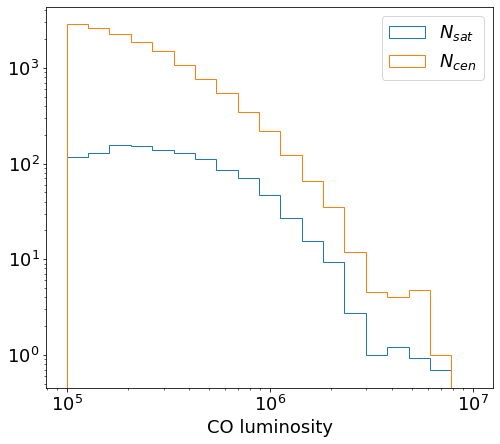

In [25]:
plt.hist(lum_lco[pos], weights = np.array(N_sat)[pos], bins = np.logspace(5, 7, 20), histtype='step', label = r'$N_{sat}$')
plt.hist(lum_lco, weights = N_cen, bins = np.logspace(5, 7, 20), histtype='step', label = r'$N_{cen}$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('CO luminosity')

Text(0.5, 0, 'CO luminosity per HI Mass')

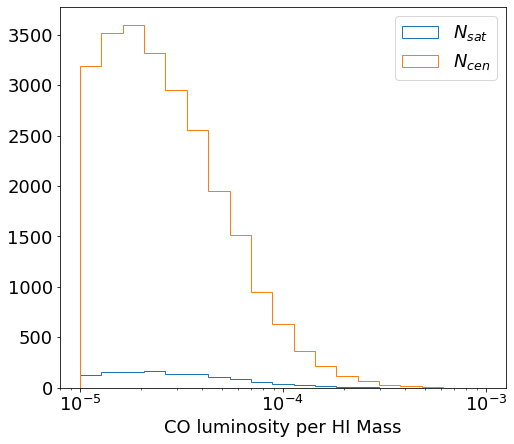

In [26]:
plt.hist((lum_lco/halo_HI)[pos], weights = np.array(N_sat)[pos], bins = np.logspace(-5, -3, 20), histtype='step', label = r'$N_{sat}$')
plt.hist(lum_lco/halo_HI, weights = N_cen, bins = np.logspace(-5, -3, 20), histtype='step', label = r'$N_{cen}$')
plt.xscale('log')
plt.legend()
plt.xlabel('CO luminosity per HI Mass')

## 2D Histograms

The simulations have 2 flux products: luminosity (in solar luminosity) and brightness temperature equivalent (in Jy/sr).

The luminosity in $L_\odot$ is given by `self.halos.Lco`. One luminosity is given for each halo in the catalog. The object for that array is `lum_lco`.

The brightness temperature equivalent in $\frac{Jy}{sr}$ is given by `self.maps`. The `self.maps` object gives the flux at every point on our `mapinst` object but we would like to know the flux for each halo. Therefore, we find the voxel closest to the position of the halo and we take the flux of that voxel to be the flux of the halo. The object for that array `lum`.

First, we do the HOD 2D histograms for the solar luminosity array:

Text(0.5, 1.0, '$M_{\\rm{HI}}$ and $L_{\\rm{CO}}$ distribution for $N_{\\rm{cen}}$')

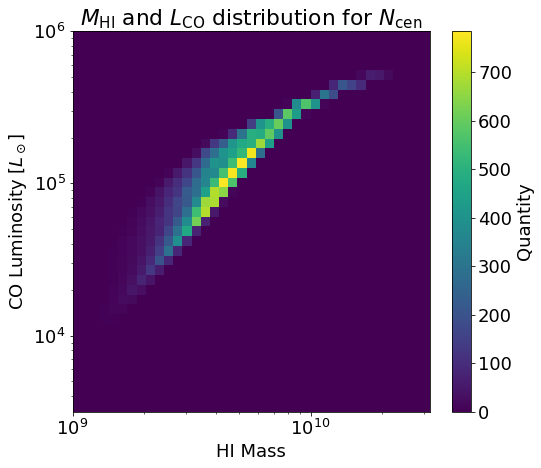

In [29]:
plt.hist2d(halo_HI, lum_lco, weights = N_cen, bins = (np.logspace(9, 10.5, 40), np.logspace(3.5, 6, 40)))
plt.colorbar(label = "Quantity")
plt.xlabel('HI Mass')
plt.ylabel(r'CO Luminosity [$L_\odot$]')
plt.xscale('log')
plt.yscale('log')
plt.title(r'$M_{\rm{HI}}$ and $L_{\rm{CO}}$ distribution for $N_{\rm{cen}}$')

Text(0.5, 1.0, '$M_{\\rm{HI}}$ and $L_{\\rm{CO}}$ distribution for $N_{\\rm{sat}}$')

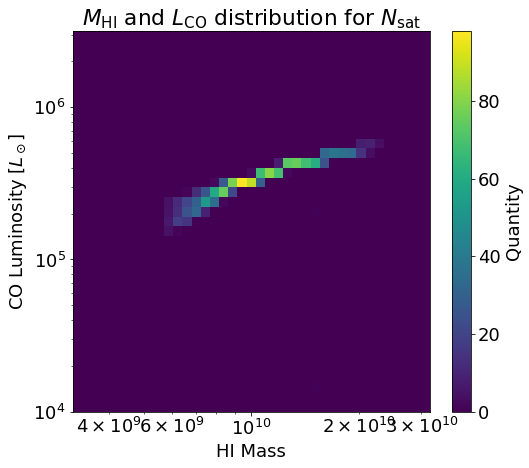

In [30]:
plt.hist2d(halo_HI[pos], lum_lco[pos], weights = N_sat[pos], bins = (np.logspace(9.5, 10.5, 40), np.logspace(4, 6.5, 40)))
plt.colorbar(label = "Quantity")
plt.xlabel('HI Mass')
plt.ylabel(r'CO Luminosity [$L_\odot$]')
plt.xscale('log')
plt.yscale('log')
plt.title(r'$M_{\rm{HI}}$ and $L_{\rm{CO}}$ distribution for $N_{\rm{sat}}$')

Then, we do it for the brightness temperature equivalent flux:

Text(0.5, 1.0, '$M_{\\rm{HI}}$ and $I_{\\rm{CO}}$ distribution for $N_{\\rm{cen}}$')

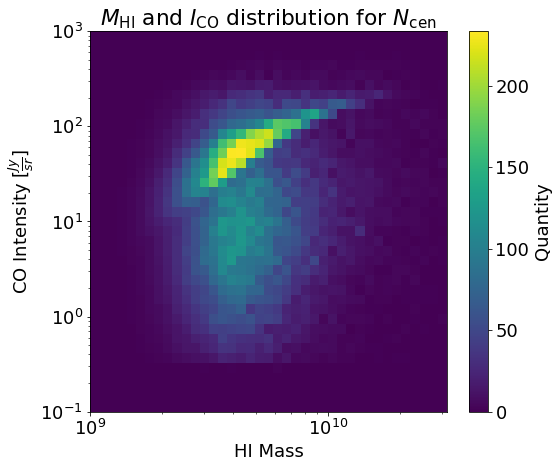

In [31]:
plt.hist2d(halo_HI, lum, weights = N_cen, bins = (np.logspace(9, 10.5, 40), np.logspace(-1, 3, 40)))
plt.colorbar(label = "Quantity")
plt.xlabel('HI Mass')
plt.ylabel(r'CO Intensity [$\frac{Jy}{sr}$]')
plt.xscale('log')
plt.yscale('log')
plt.title(r'$M_{\rm{HI}}$ and $I_{\rm{CO}}$ distribution for $N_{\rm{cen}}$')

Text(0.5, 1.0, '$M_{\\rm{HI}}$ and $I_{\\rm{CO}}$ distribution for $N_{\\rm{sat}}$')

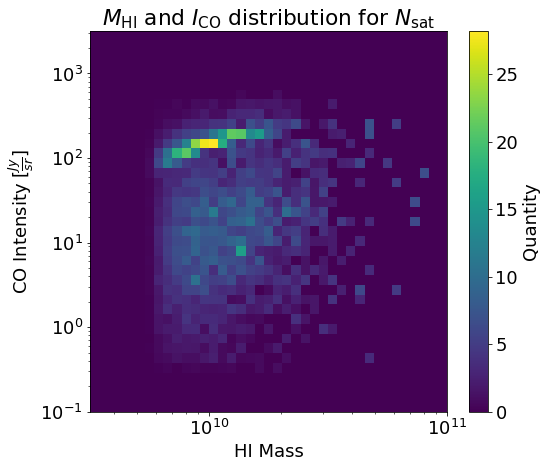

In [35]:
plt.hist2d(halo_HI[pos], lum[pos], weights = N_sat[pos], bins = (np.logspace(9.5, 11, 40), np.logspace(-1, 3.5, 40)))
plt.colorbar(label = "Quantity")
plt.xlabel('HI Mass')
plt.ylabel(r'CO Intensity [$\frac{Jy}{sr}$]')
plt.xscale('log')
plt.yscale('log')
plt.title(r'$M_{\rm{HI}}$ and $I_{\rm{CO}}$ distribution for $N_{\rm{sat}}$')

## Redshift Discrimination

We want to investigate "the cliff" observed on the 2D histograms for CO intensity. Is it dependent on redshift? We plot the histogram for the higher and lower redshift halos.

In [39]:
z_range = np.max(halo_zs) - np.min(halo_zs)
low_z = halo_zs < np.min(halo_zs) + 0.5*z_range
high_z = halo_zs > np.min(halo_zs) + 0.5*z_range

Text(0, 0.5, 'Quantity')

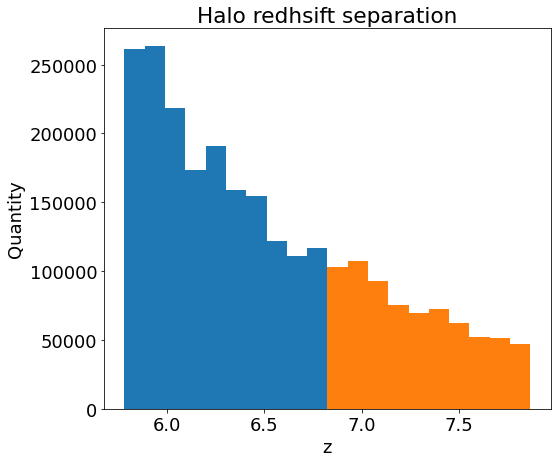

In [48]:
plt.hist(halo_zs[low_z])
plt.hist(halo_zs[high_z])
plt.title('Halo redhsift separation')
plt.xlabel('z')
plt.ylabel('Quantity')

Lower redshift:

Text(0.5, 1.0, '$M_{\\rm{HI}}$ and $I_{\\rm{CO}}$ for $N_{\\rm{cen}}$ for lower $z$')

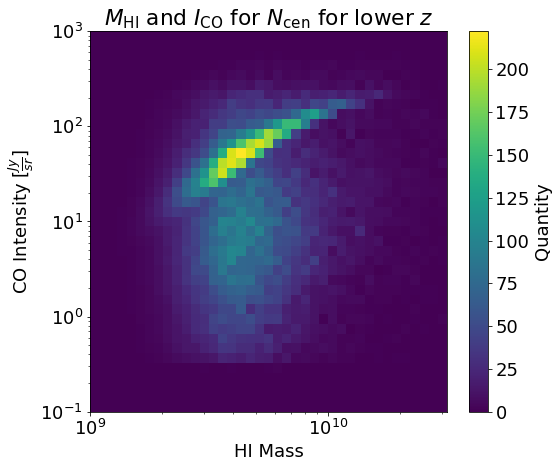

In [58]:
plt.hist2d(halo_HI[low_z], lum[low_z], weights = N_cen[low_z], bins = (np.logspace(9, 10.5, 40), np.logspace(-1, 3, 40)))
plt.colorbar(label = "Quantity")
plt.xlabel('HI Mass')
plt.ylabel(r'CO Intensity [$\frac{Jy}{sr}$]')
plt.xscale('log')
plt.yscale('log')
plt.title(r'$M_{\rm{HI}}$ and $I_{\rm{CO}}$ for $N_{\rm{cen}}$ for lower $z$')

Higher redshift:

Text(0.5, 1.0, '$M_{\\rm{HI}}$ and $I_{\\rm{CO}}$ for $N_{\\rm{cen}}$ for higher $z$')

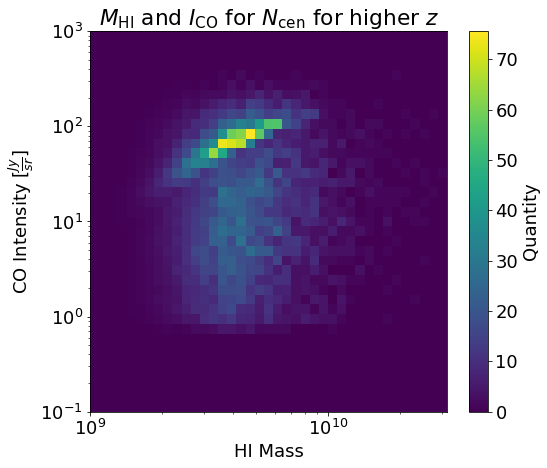

In [59]:
plt.hist2d(halo_HI[high_z], lum[high_z], weights = N_cen[high_z], bins = (np.logspace(9, 10.5, 40), np.logspace(-1, 3, 40)))
plt.colorbar(label = "Quantity")
plt.xlabel('HI Mass')
plt.ylabel(r'CO Intensity [$\frac{Jy}{sr}$]')
plt.xscale('log')
plt.yscale('log')
plt.title(r'$M_{\rm{HI}}$ and $I_{\rm{CO}}$ for $N_{\rm{cen}}$ for higher $z$')

The "cliff" is present both at higher and lower redshift

## Log halo mass discrimination

In [64]:
loghalo_ms = np.log10(halo_ms)

In [65]:
logm_range = np.max(loghalo_ms) - np.min(loghalo_ms)
low_logm = loghalo_ms < np.min(loghalo_ms) + 0.5*logm_range
high_logm = loghalo_ms > np.min(loghalo_ms) + 0.5*logm_range

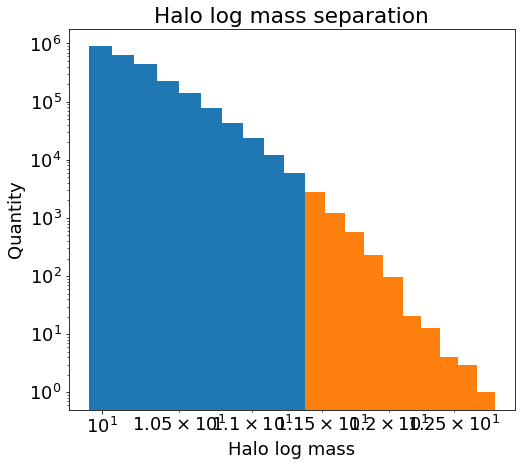

In [68]:
plt.hist(loghalo_ms[low_logm])
plt.hist(loghalo_ms[high_logm])
plt.title('Halo log mass separation')
plt.xlabel('Halo log mass')
plt.ylabel('Quantity')
plt.xscale('log')
plt.yscale('log')

Text(0.5, 1.0, '$M_{\\rm{HI}}$ and $I_{\\rm{CO}}$ for $N_{\\rm{cen}}$ for lower log mass')

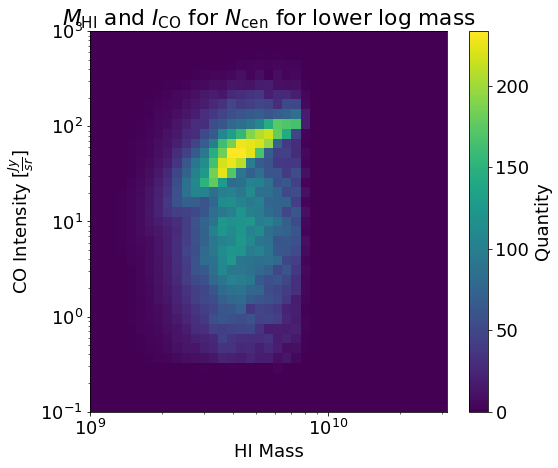

In [69]:
plt.hist2d(halo_HI[low_logm], lum[low_logm], weights = N_cen[low_logm], bins = (np.logspace(9, 10.5, 40), np.logspace(-1, 3, 40)))
plt.colorbar(label = "Quantity")
plt.xlabel('HI Mass')
plt.ylabel(r'CO Intensity [$\frac{Jy}{sr}$]')
plt.xscale('log')
plt.yscale('log')
plt.title(r'$M_{\rm{HI}}$ and $I_{\rm{CO}}$ for $N_{\rm{cen}}$ for lower log mass')

Text(0.5, 1.0, '$M_{\\rm{HI}}$ and $I_{\\rm{CO}}$ for $N_{\\rm{cen}}$ for higher log mass')

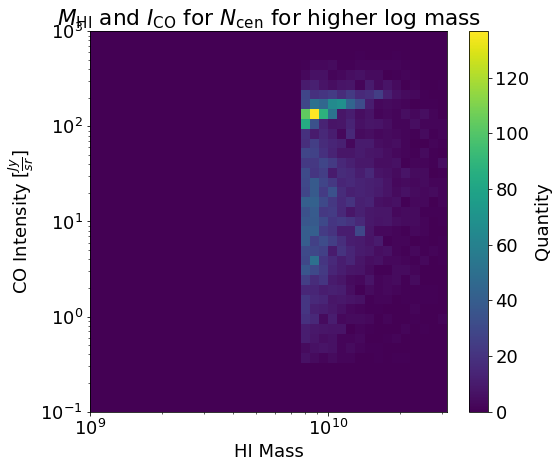

In [70]:
plt.hist2d(halo_HI[high_logm], lum[high_logm], weights = N_cen[high_logm], bins = (np.logspace(9, 10.5, 40), np.logspace(-1, 3, 40)))
plt.colorbar(label = "Quantity")
plt.xlabel('HI Mass')
plt.ylabel(r'CO Intensity [$\frac{Jy}{sr}$]')
plt.xscale('log')
plt.yscale('log')
plt.title(r'$M_{\rm{HI}}$ and $I_{\rm{CO}}$ for $N_{\rm{cen}}$ for higher log mass')